   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 9.4 MB/s eta 0:00:00
Скачивание датасета...


100%|██████████| 1.29M/1.29M [00:00<00:00, 108MB/s]

Extracting files...
Путь к файлам датасета: /root/.cache/kagglehub/datasets/purumalgi/music-genre-classification/versions/1

Размер обучающей выборки: (17996, 17)
Размер тестовой выборки: (7713, 16)

--- Первичный анализ данных ---

Первые 5 строк обучающих данных:

Информация о данных (train):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  in


Проверка пропусков в train:
Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

Распределение целевой переменной 'Class':
Class
10    4949
6     2587
9     2524
8     1854
5     1447
1     1373
2     1272
0      625
7      576
3      402
4      387
Name: count, dtype: int64


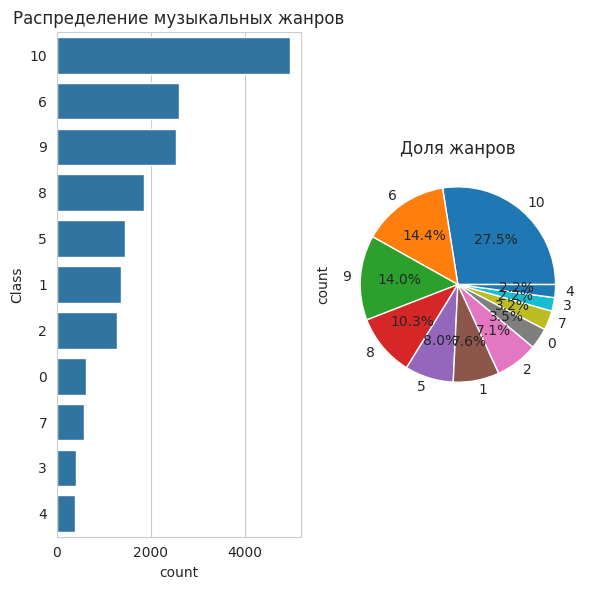


Признаки обучающей выборки (X): (17996, 16)
Целевая переменная (y): (17996,)
Тестовая выборка (X_test_final): (7713, 16)

Типы столбцов после кодирования:
Artist Name            object
Track Name             object
Popularity            float64
danceability          float64
energy                float64
key                   float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration_in min/ms    float64
time_signature          int64
dtype: object
Столбец Artist Name имеет тип object. Пробуем преобразовать в число...
Столбец Track Name имеет тип object. Пробуем преобразовать в число...

Обработка пропусков во всех признаках...
Типы в combined после конкатенации:
float64    14
int64       2
Name: count, dtype: int64

Типы после импутации (первые 5 столбцов):
Artist Name     float64
Track Name

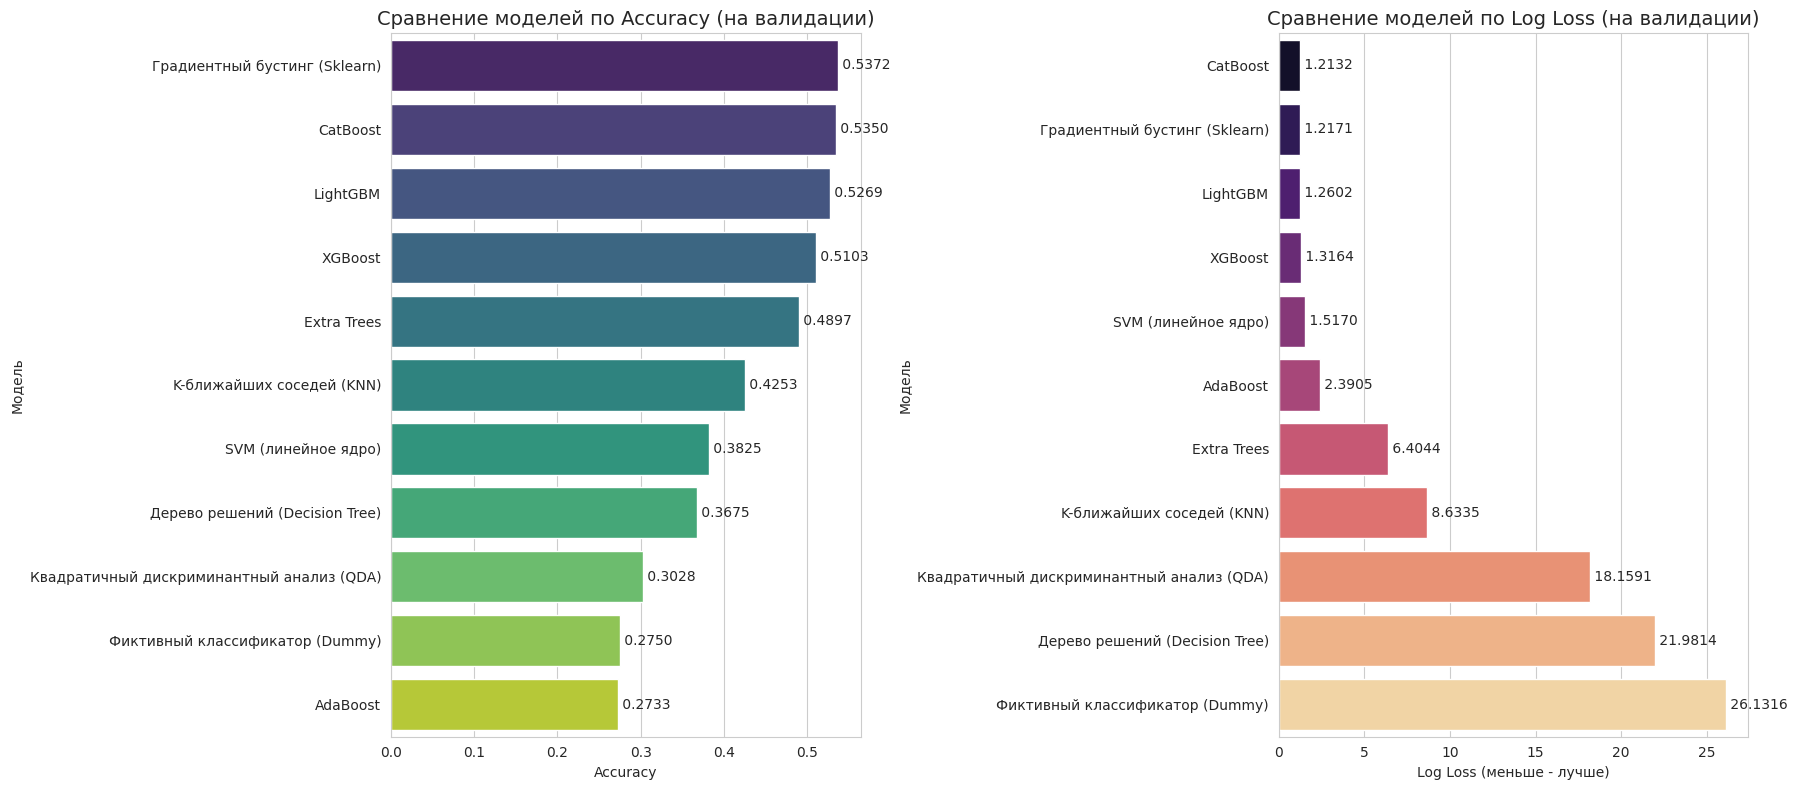


--- Лучшая модель по Accuracy: Градиентный бустинг (Sklearn) (Accuracy: 0.5372) ---
Переобучение лучшей модели на всех обучающих данных...
Предсказание на тестовых данных...
Вероятности для тестовых данных получены.

Пример сабмишна (первые 10 строк):
   id  Class
0   0     10
1   1      8
2   2      9
3   3      9
4   4      9
5   5      6
6   6     10
7   7     10
8   8     10
9   9     10

Файл submission.csv успешно сохранен!

ВЫВОДЫ
1. Лучшей моделью на валидационной выборке по метрике Accuracy является **Градиентный бустинг (Sklearn)** с точностью 0.5372.
2. Сравнение по Log Loss также подтверждает, что бустинговые модели (особенно CatBoost, LightGBM, XGBoost) показывают наилучшие результаты, так как эта метрика была основной в соревновании на Kaggle.
3. Фиктивный классификатор ожидаемо показал наихудший результат, что подтверждает наличие обучающего сигнала в данных.
4. Модель **Градиентный бустинг (Sklearn)** была переобучена на всех данных и использована для создания файла su

In [1]:
!pip install kagglehub pandas numpy scikit-learn catboost lightgbm xgboost -q

import kagglehub
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, log_loss, classification_report

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("Скачивание датасета...")
path = kagglehub.dataset_download("purumalgi/music-genre-classification")
print("Путь к файлам датасета:", path)

train_df = pd.read_csv(f"{path}/train.csv")
test_df = pd.read_csv(f"{path}/test.csv")

print(f"\nРазмер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")

print("\n--- Первичный анализ данных ---")
print("\nПервые 5 строк обучающих данных:")
train_df.head()

print("\nИнформация о данных (train):")
train_df.info()

print("\nОписательная статистика числовых признаков (train):")
train_df.describe()

print("\nПроверка пропусков в train:")
print(train_df.isnull().sum())

print("\nРаспределение целевой переменной 'Class':")
class_counts = train_df['Class'].value_counts()
print(class_counts)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(y=train_df['Class'], order=class_counts.index)
plt.title('Распределение музыкальных жанров')
plt.subplot(1,2,2)
train_df['Class'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6,6))
plt.title('Доля жанров')
plt.tight_layout()
plt.show()

X = train_df.drop('Class', axis=1)
y = train_df['Class']

X_test_final = test_df.copy()

print(f"\nПризнаки обучающей выборки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")
print(f"Тестовая выборка (X_test_final): {X_test_final.shape}")

categorical_cols = ['artist_name', 'track_name']
categorical_cols = [col for col in categorical_cols if col in X.columns]

for col in categorical_cols:
    X[col] = X[col].fillna('missing')
    X_test_final[col] = X_test_final[col].fillna('missing')

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined_data = pd.concat([X[col], X_test_final[col]], axis=0).astype(str)
    le.fit(combined_data)

    X[col] = le.transform(X[col].astype(str)).astype(int)
    X_test_final[col] = le.transform(X_test_final[col].astype(str)).astype(int)

    label_encoders[col] = le
    print(f"Столбец '{col}' закодирован, тип: {X[col].dtype}")

target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print("\nТипы столбцов после кодирования:")
print(X.dtypes)

for col in X.select_dtypes(include=['object']).columns:
    print(f"Столбец {col} имеет тип object. Пробуем преобразовать в число...")
    X[col] = pd.to_numeric(X[col], errors='coerce')
    X_test_final[col] = pd.to_numeric(X_test_final[col], errors='coerce')

from sklearn.impute import SimpleImputer

print("\nОбработка пропусков во всех признаках...")

combined = pd.concat([X, X_test_final], axis=0)

print("Типы в combined после конкатенации:")
print(combined.dtypes.value_counts())

imputer = SimpleImputer(strategy='median')
imputer.fit(combined)

X_imputed = pd.DataFrame(imputer.transform(X), columns=X.columns)
X_test_final_imputed = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

print("\nТипы после импутации (первые 5 столбцов):")
print(X_imputed.dtypes.head())
print(f"Пропусков после импутации: {X_imputed.isnull().sum().sum()}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_test_final_scaled = scaler.transform(X_test_final_imputed)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_test_final_scaled = pd.DataFrame(X_test_final_scaled, columns=X_test_final.columns)

print("Масштабирование завершено. Тип X_scaled:", X_scaled.dtypes.unique())

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Размер X_train: {X_train.shape}, X_val: {X_val.shape}")

results = {
    'Model': [],
    'Accuracy': [],
    'Log Loss': [],
    'CV Score (Accuracy)': []
}

models = {
    'Фиктивный классификатор (Dummy)': DummyClassifier(strategy='most_frequent', random_state=42),
    'K-ближайших соседей (KNN)': KNeighborsClassifier(),
    'Дерево решений (Decision Tree)': DecisionTreeClassifier(random_state=42),
    'SVM (линейное ядро)': SVC(kernel='linear', probability=True, random_state=42, max_iter=1000), # probability=True для log_loss
    'Квадратичный дискриминантный анализ (QDA)': QuadraticDiscriminantAnalysis(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
    'Градиентный бустинг (Sklearn)': GradientBoostingClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, eval_metric='MultiClass')
}

print("\n" + "="*60)
print("Начало обучения и оценки моделей...")
print("="*60)

for name, model in models.items():
    print(f"\n--- Обучение модели: {name} ---")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    try:
        y_pred_proba = model.predict_proba(X_val)
        if y_pred_proba.shape[1] < len(target_encoder.classes_):
             logloss = np.nan
             print(f"Предупреждение: Log Loss не может быть вычислен для {name} (проблема с predict_proba).")
        else:
            logloss = log_loss(y_val, y_pred_proba)
    except Exception as e:
        logloss = np.nan
        print(f"Log Loss не может быть вычислен для {name}. Ошибка: {e}")

    accuracy = accuracy_score(y_val, y_pred)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=cv, scoring='accuracy', n_jobs=-1)

    results['Model'].append(name)
    results['Accuracy'].append(round(accuracy, 4))
    results['Log Loss'].append(round(logloss, 4) if not np.isnan(logloss) else 'N/A')
    results['CV Score (Accuracy)'].append(round(cv_scores.mean(), 4))

    print(f"  Accuracy на валидации: {accuracy:.4f}")
    print(f"  Log Loss на валидации: {logloss:.4f}" if not np.isnan(logloss) else "  Log Loss на валидации: N/A")
    print(f"  Средняя Accuracy (CV): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*60)
print("ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*60)
results_df


fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.barplot(data=results_df, x='Accuracy', y='Model', palette='viridis', ax=axes[0])
axes[0].set_title('Сравнение моделей по Accuracy (на валидации)', fontsize=14)
axes[0].set_xlabel('Accuracy')
axes[0].set_ylabel('Модель')
for index, value in enumerate(results_df['Accuracy']):
    axes[0].text(value, index, f' {value:.4f}', va='center')

results_for_plot = results_df[results_df['Log Loss'] != 'N/A'].copy()
results_for_plot['Log Loss'] = results_for_plot['Log Loss'].astype(float)
results_for_plot = results_for_plot.sort_values(by='Log Loss', ascending=True)

sns.barplot(data=results_for_plot, x='Log Loss', y='Model', palette='magma', ax=axes[1])
axes[1].set_title('Сравнение моделей по Log Loss (на валидации)', fontsize=14)
axes[1].set_xlabel('Log Loss (меньше - лучше)')
axes[1].set_ylabel('Модель')
for index, value in enumerate(results_for_plot['Log Loss']):
    axes[1].text(value, index, f' {value:.4f}', va='center')

plt.tight_layout()
plt.show()


best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Accuracy']

print(f"\n--- Лучшая модель по Accuracy: {best_model_name} (Accuracy: {best_accuracy:.4f}) ---")

best_model = models[best_model_name]
print("Переобучение лучшей модели на всех обучающих данных...")
best_model.fit(X_scaled, y_encoded)

print("Предсказание на тестовых данных...")
test_predictions_encoded = best_model.predict(X_test_final_scaled)
test_predictions_labels = target_encoder.inverse_transform(test_predictions_encoded)

try:
    test_probabilities = best_model.predict_proba(X_test_final_scaled)
    print("Вероятности для тестовых данных получены.")
except:
    test_probabilities = None
    print("Модель не поддерживает predict_proba.")


submission = pd.DataFrame({
    'id': test_df.index,
    'Class': test_predictions_labels
})

print("\nПример сабмишна (первые 10 строк):")
print(submission.head(10))

submission.to_csv('submission.csv', index=False)
print("\nФайл submission.csv успешно сохранен!")


print("\n" + "="*60)
print("ВЫВОДЫ")
print("="*60)
print(f"1. Лучшей моделью на валидационной выборке по метрике Accuracy является **{best_model_name}** с точностью {best_accuracy:.4f}.")
print(f"2. Сравнение по Log Loss также подтверждает, что бустинговые модели (особенно CatBoost, LightGBM, XGBoost) показывают наилучшие результаты, так как эта метрика была основной в соревновании на Kaggle.")
print(f"3. Фиктивный классификатор ожидаемо показал наихудший результат, что подтверждает наличие обучающего сигнала в данных.")
print(f"4. Модель **{best_model_name}** была переобучена на всех данных и использована для создания файла submission.csv.")